<a href="https://colab.research.google.com/github/Dahamey/Dahamey.github.io/blob/main/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df_raw = pd.read_csv("wine-reviews.csv",
                     usecols = ["country", "description", "points", "price", "variety", "winery"])

df = df_raw.copy()

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


Text(0.5, 0, 'Points')

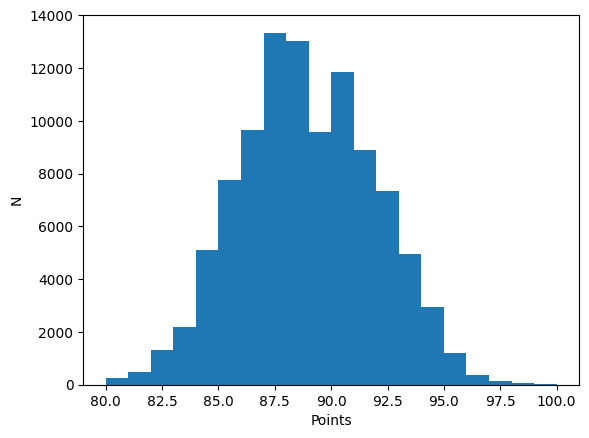

In [ ]:
plt.hist(df["points"], bins = 20)
plt.ylabel("N")
plt.xlabel("Points")

In [ ]:
df["label"] = (df.points >= 90).astype(int)
df = df[['description', 'label']]

In [ ]:
# Instead of using train_test_split fct, we're going to split the data in another way
# 80% training, 10% validation and 10% test

train, val, test = np.split(df.sample(frac = 1),  [int(0.8 * len(df)), int( 0.9* len(df))])

In [ ]:
len(train), len(test), len(val)

(80399, 10050, 10050)

In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):

  """ a utility function that converts each training, validation,
   and test set DataFrame into a tf.data.Dataset, then shuffles and
    batches the data."""

  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [11]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [19]:
# len of train 80399/ batch size 1024 = nb of batches 78, so we have 79 batches, for the batch nb 0 :
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'This frothy wine opens with floral aromas that recall acacia flower, dried chamomile and a whiff of honey. The palate offers yellow apple, peach and a hint of bread crust alongside brisk acidity. It ends on a note of bitter almond.',
        b'Pink fruited and light, with an attractive herbal character. The crisp acidity cuts right through the rich mouthfeel.Bright and lively, the finish has a grapefruit note that lends lift.',
        b'The winery blends 84% Cabernet Sauvignon with 11% Petit Verdot and 5% Malbec for this high-end red. Burly in tobacco and cedar, it also offers a floral, high-toned spirit built around juicy cranberry on the palate. With well-integrated tannins and oak, it finishes in a note of bittersweet chocolate.',
        ...,
        b'A concentrated wine, although with some of the delicacy of the 1998 vintage, showing structure, tannins and ripeness. The finish is full of chocolate and sweet coffee flavor

#  Embedding + Model

In [22]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype = tf.string, trainable = True)

In [24]:
# Transforming text into vector of numbers
hub_layer(list(train_data)[0][0])  # list(train_data)[0][0] We need to only pas the strings

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.59385234, -0.3689874 , -0.16889344, ...,  0.11179138,
        -0.04340827, -0.09342901],
       [ 0.24615264, -0.20879838,  0.00636331, ...,  0.0158249 ,
        -0.3518094 ,  0.0423434 ],
       [-0.20411487, -0.21703929, -0.33702686, ..., -0.14501093,
         0.02010807,  0.07091057],
       ...,
       [ 0.27701467, -0.23245515, -0.0546173 , ..., -0.03448763,
        -0.06329071, -0.10010995],
       [ 0.23551929, -0.3411995 , -0.03437976, ...,  0.11991812,
        -0.3089275 , -0.00728525],
       [ 0.451488  , -0.23138168,  0.15141293, ...,  0.1477019 ,
         0.05605777, -0.29173276]], dtype=float32)>

In [37]:
# Build the model
model = tf.keras.Sequential()

# first transformation is : text to numerical value :
model.add(hub_layer)

# adding a classic dense 2 layers and the output
model.add(tf.keras.layers.Dense(units = 16, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units = 16, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units = 1, activation ="sigmoid"))

In [38]:
# Compile the model :
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(), # because we're doing binary classification
              metrics = ["accuracy"])

In [39]:
model.evaluate(train_data)

79/79 [==============================] - 16s 195ms/step - loss: 0.6638 - accuracy: 0.6351


[0.6637741923332214, 0.635094940662384]

In [40]:
model.evaluate(val_data)

10/10 [==============================] - 2s 179ms/step - loss: 0.6655 - accuracy: 0.6316


[0.6654961705207825, 0.6316418051719666]

In [41]:
history = model.fit(train_data, epochs = 5, validation_data= val_data)

Epoch 1/5
79/79 [==============================] - 137s 2s/step - loss: 0.5704 - accuracy: 0.6871 - val_loss: 0.4494 - val_accuracy: 0.8079
Epoch 2/5
79/79 [==============================] - 112s 1s/step - loss: 0.3865 - accuracy: 0.8412 - val_loss: 0.3934 - val_accuracy: 0.8168
Epoch 3/5
79/79 [==============================] - 127s 2s/step - loss: 0.3205 - accuracy: 0.8736 - val_loss: 0.4069 - val_accuracy: 0.8198
Epoch 4/5
79/79 [==============================] - 119s 2s/step - loss: 0.2935 - accuracy: 0.8867 - val_loss: 0.4188 - val_accuracy: 0.8192
Epoch 5/5
79/79 [==============================] - 177s 2s/step - loss: 0.2754 - accuracy: 0.8957 - val_loss: 0.4353 - val_accuracy: 0.8219


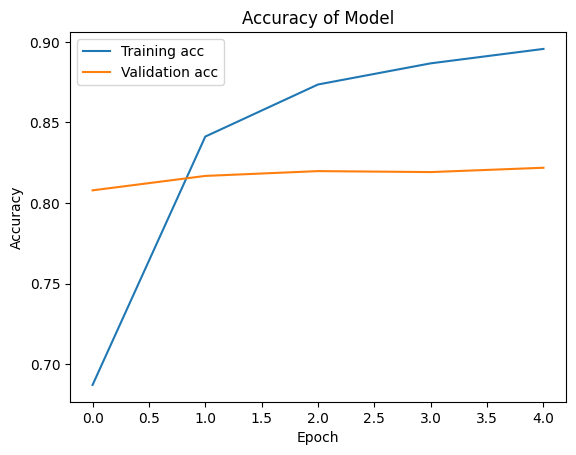

In [43]:
"""
plt.plot(history.history['accuracy'], label = "Training acc")
plt.plot(history.history['val_accuracy'], label = "Validation acc")
plt.title("Accuracy of Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
"""

In [44]:
# test the model on new unseen data :
model.evaluate(test_data)

10/10 [==============================] - 2s 177ms/step - loss: 0.4333 - accuracy: 0.8229


[0.43334928154945374, 0.8228855729103088]

# LSTM

In [51]:
# Create encoder for our text, because the computer doesn't understand words:

# 2000 is the max of words that we're going to remember:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)

# Our train_data is composed of text and a label, bu the encoder only need the sentences (text)
encoder.adapt(train_data.map(lambda text, label: text))

In [52]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20] # some words that are encoded in our encoder

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [53]:
# Creating the model
model = tf.keras.Sequential([
    # the encoder is what is going to, basically, vectorize our text
    encoder,

    # Then, we need to have an embedding for the  vectorized text
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True  # so we can handle various sequence lengths
    ),

    # Add the LSTM layers
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [54]:
# Compile the model :
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [55]:
model.evaluate(train_data)
model.evaluate(val_data)

10/10 [==============================] - 2s 150ms/step - loss: 0.6937 - accuracy: 0.4260


[0.6937236785888672, 0.4259701371192932]

In [57]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
79/79 [==============================] - 52s 568ms/step - loss: 0.5975 - accuracy: 0.6748 - val_loss: 0.4301 - val_accuracy: 0.8037
Epoch 2/5
79/79 [==============================] - 40s 503ms/step - loss: 0.3913 - accuracy: 0.8238 - val_loss: 0.3595 - val_accuracy: 0.8349
Epoch 3/5
79/79 [==============================] - 37s 462ms/step - loss: 0.3564 - accuracy: 0.8415 - val_loss: 0.3539 - val_accuracy: 0.8414
Epoch 4/5
79/79 [==============================] - 37s 462ms/step - loss: 0.3468 - accuracy: 0.8469 - val_loss: 0.3531 - val_accuracy: 0.8361
Epoch 5/5
79/79 [==============================] - 42s 533ms/step - loss: 0.3433 - accuracy: 0.8489 - val_loss: 0.3514 - val_accuracy: 0.8416


In [58]:
model.evaluate(test_data)

10/10 [==============================] - 3s 317ms/step - loss: 0.3498 - accuracy: 0.8382


[0.3497522473335266, 0.8382089734077454]